### ****Transformers****
are a relatively new architecture that gained significant popularity, especially in the field of NLP. Vaswani et al. introduced them in the paper "Attention Is All You Need" in 2017. Transformers rely on self-attention mechanisms to capture global dependencies between input elements. They can process inputs in parallel, making them highly parallelizable and efficient for training on modern hardware. Transformers have achieved state-of-the-art results in various NLP tasks, including language translation, text summarization, and sentiment analysis

#### ****Compared to CNNs and RNNs, Transformers have several advantages****:

**Parallelization**:  Transformers can process input elements in parallel, making them faster to train and more efficient on hardware that supports parallel operations;

**Attention mechanism**: Transformers use self-attention to capture global dependencies in the input sequence, allowing them to attend to relevant context across the entire sequence. This is particularly useful in NLP tasks where long-range dependencies are essential.

**No sequential processing**: Unlike RNNs, Transformers do not process input sequentially. They can take advantage of parallel processing and are not limited by the sequential nature of RNNs, enabling faster training and inference.

#### **Main components of Transformer architecture**:

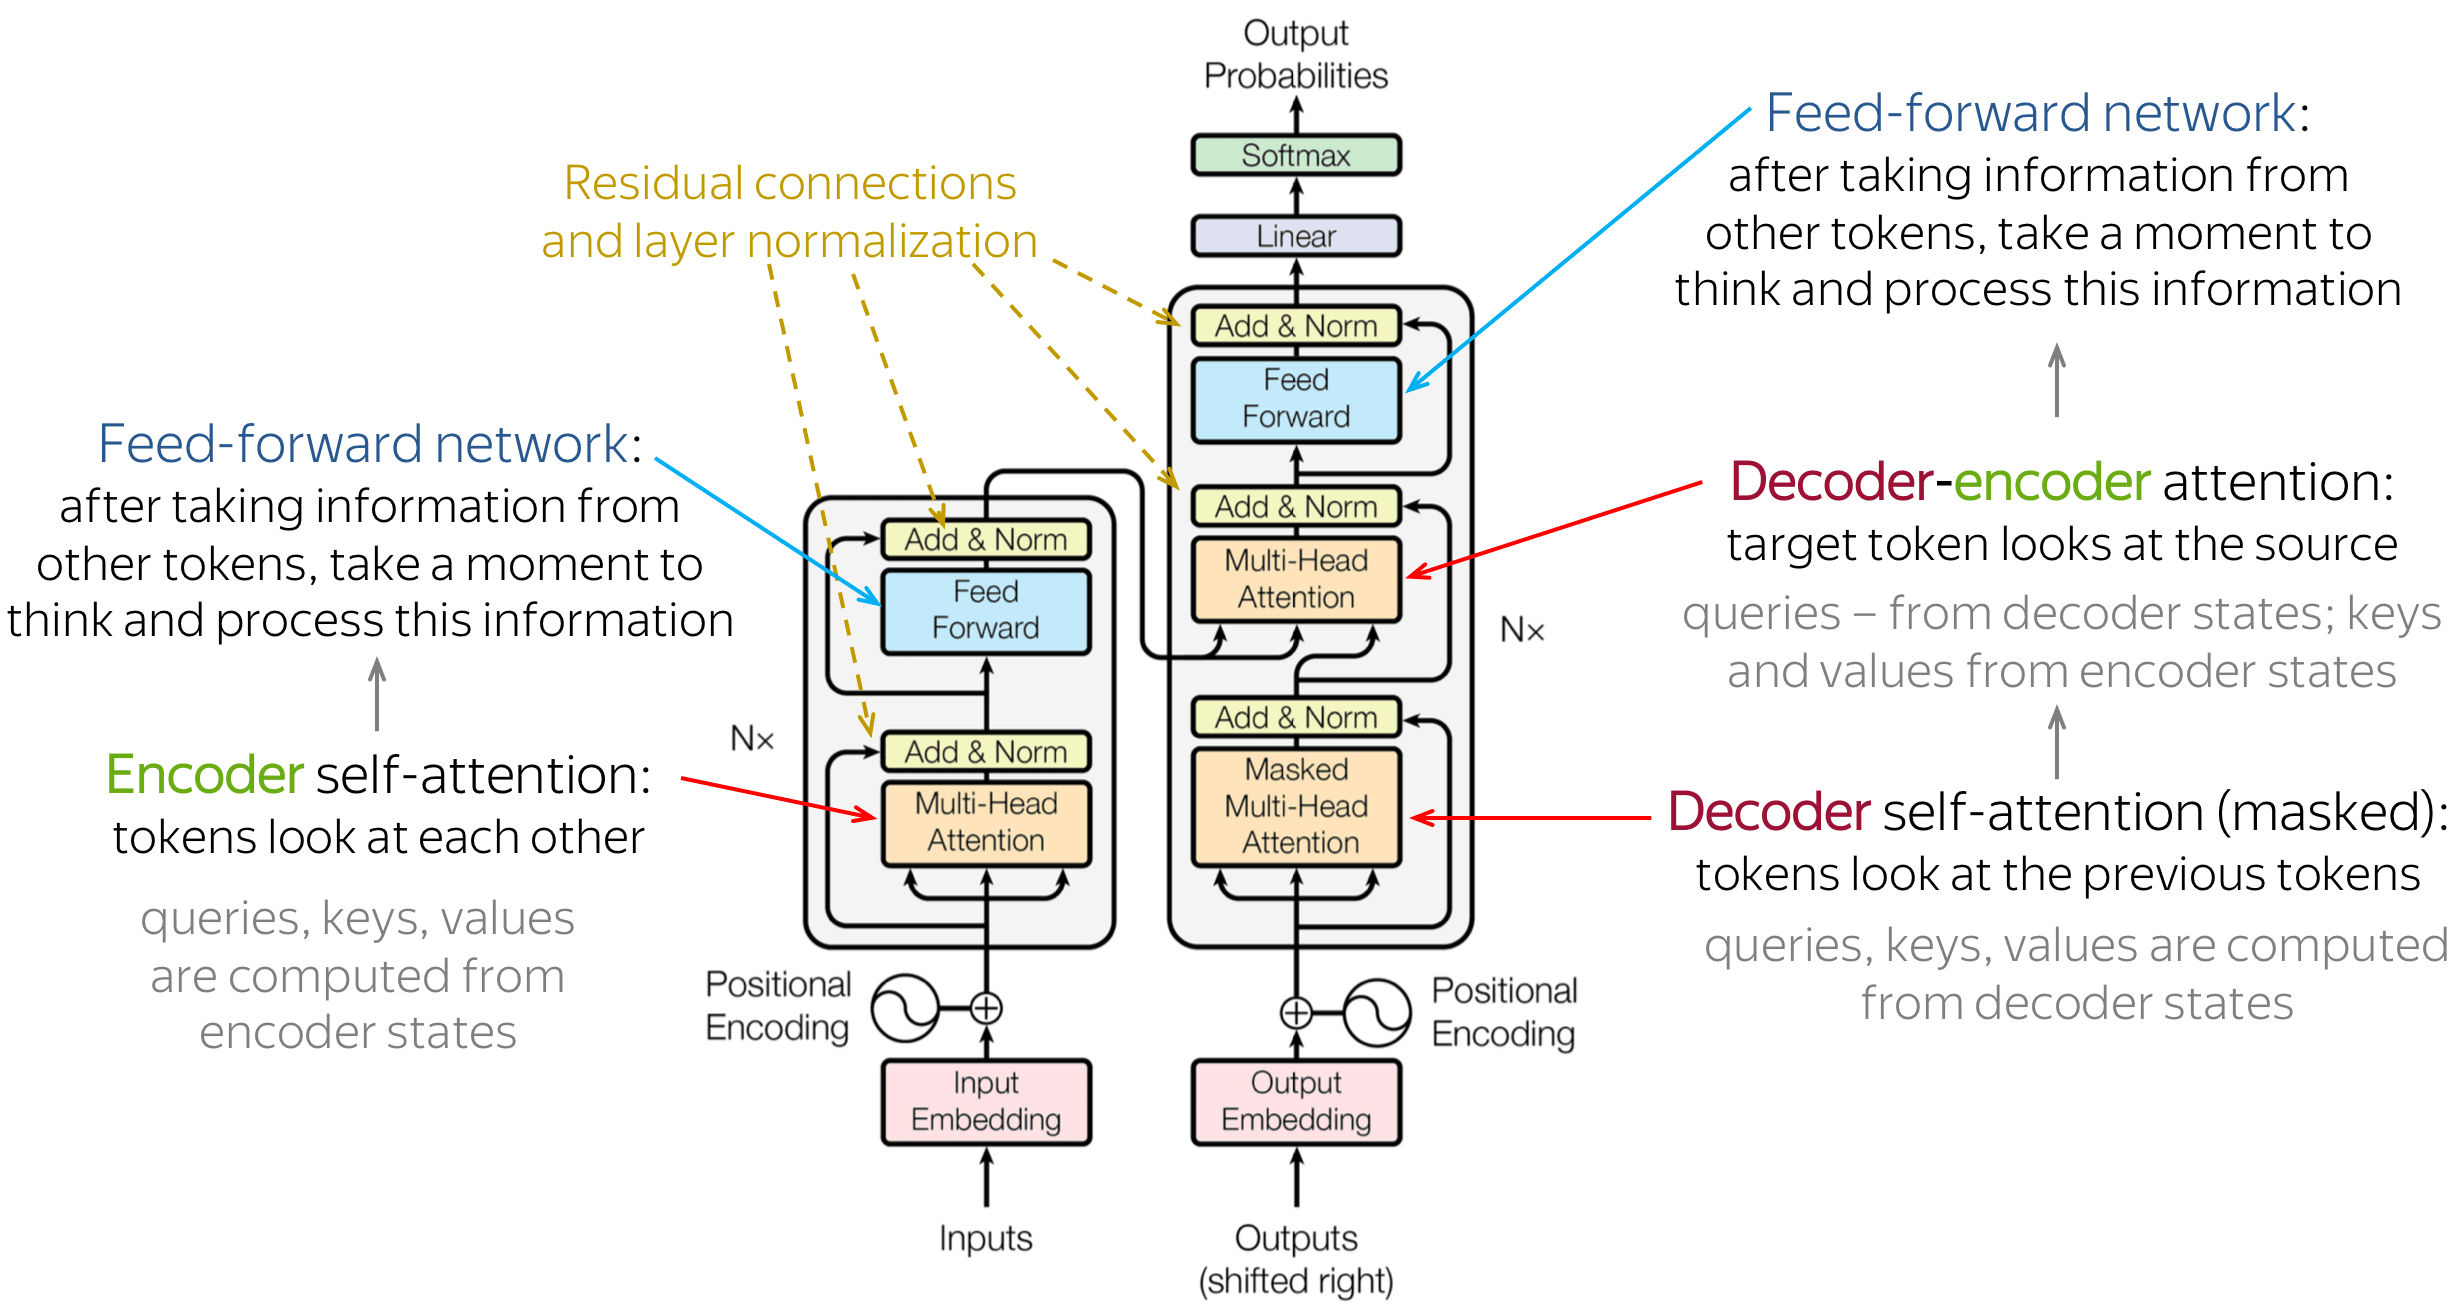

The **Transformer** architecture is made up of two main parts: the **encoder** and the **decoder**. These parts have several layers that use **attention** and **self-attention** methods to handle input and output sequences. The **encoder** changes the input sequence into a hidden representation, and the **decoder** creates the output sequence using the **encoder**'s hidden representation. The **Transformer** achieves excellent performance on various language processing tasks by combining these two components. Here are a few notes:

1. In more detail, the **encoder** takes the input sequence and converts it into a series of embeddings. These embeddings are then processed through a stack of identical layers in the encoder. Each layer consists of two sublayers: a **self-attention** layer and a **feedforward** layer. The self-attention layer helps the encoder focus on different parts of the input sequence and understand long-range relationships. In contrast, the feedforward layer applies a nonlinear transformation to the hidden representation;

2. Similarly, the **decoder** also has a stack of identical layers. However, each layer in the decoder has three sublayers: a **self-attention** layer, an **encoder-decoder** attention layer, and a **feedforward** layer. The self-attention layer helps the decoder attend to different parts of the output sequence. In contrast, the encoder-decoder attention layer lets the decoder consider different parts of the input sequence;

3. **Attention** is a mechanism that allows the model to concentrate on specific input aspects when making predictions selectively. In the Transformer architecture, attention is used in both the **encoder** and **decoder**. It calculates a weighted sum of the input sequence values, where the similarity between the query and the keys determines the weights. This mechanism enables the model to concentrate on various segments of the input sequence depending on the particular task;

4. The **self-attention** mechanism is a specific type of attention used in the Transformer architecture. It operates on the input sequence and transforms it into query, key, and value vectors. The query vectors determine the attention weights for each position in the input sequence based on their similarity to the key vectors. The value vectors are then multiplied by the attention weights and summed up to create a weighted representation of the input sequence. This representation becomes the input for the next layer, enabling the model to attend to different parts of the sequence and capture long-range dependencies.

#### **Implementing PositionalEmbedding layers**
##### **Positional encoding (positional_encoding function)**

In Transformer models, the encoder and decoder components employ a common approach to convert input tokens into vectors:

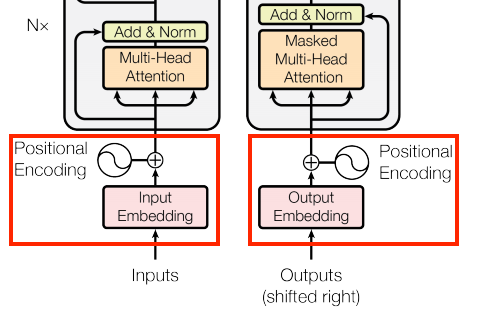

the purpose of the positional encoding function in transformers is to introduce position information into the model, enabling it to understand the sequential nature of the input data and effectively perform tasks where the order of elements matters, such as language translation or language understanding tasks.

**The following formula gives the method to compute the positional encoding:**

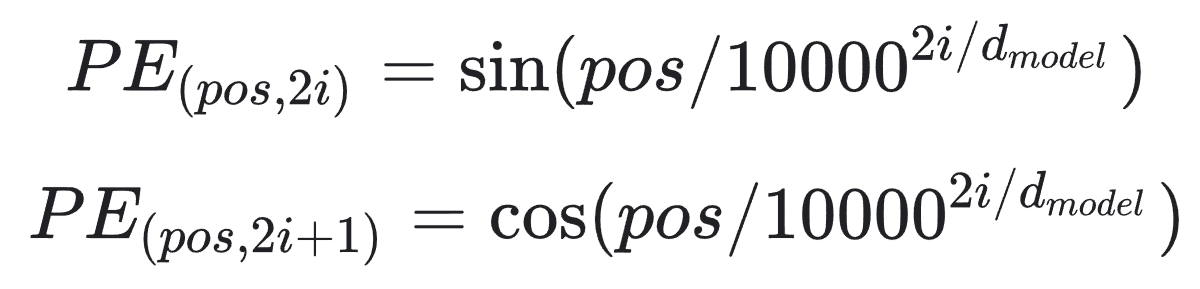

Where "pos" is the position and "i" is the dimension. "d_model" is the dimension of the embedding vector. In other words, each dimension of the positional encoding corresponds to a sinusoid. The position determines the wavelength of each sinusoid, and the dimension determines the frequency. The positional encoding is calculated using sine and cosine functions with different frequencies. The frequencies form a geometric progression from "2/pi" to "10000*2/pi".

Let's implement this layer in the code:

In [15]:
import numpy as np
import tensorflow as tf

def Positional_encoding(length: int, depth: int):
    """
    Generates a positional encoding for a given length and depth.

    Args:
        length (int): The length of the input sequence.
        depth (int): The depth that represents the dimensionality of the encoding.

    Returns:
        tf.Tensor: The positional encoding of shape (length, depth).
    """ 
    depth = depth / 2

    positions = np.arange(length)[:, np.newaxis]  # (seq, 1)
    depths = np.arange(depth)[np.newaxis, :]/depth # (1, depth)

    angle_rates = 1 / (10000*depths) # (1, depth)
    angle_rads = positions * angle_rates # (pos, depth)
    pos_encoding = np.concatenate([np.sin(angle_rads), np.cos(angle_rads)], axis=-1)

    return tf.cast(pos_encoding, dtype=tf.float32)

#### **PositionalEmbedding layer**

Now that we know how to implement positional encoding, we can create a custom layer that will combine positional encoding with token embedding. This layer will be used in Encoder and Decoder layers:

In [16]:
class PositionalEmbedding(tf.keras.layers.Layer):
    """
    A positional embedding layer combines the input embedding with a positional encoding that helps the Transformer
    to understand the relative position of the input tokens. This layer takes the input of tokens and converts them
    into sequence of embeddings vector. Then, it adds the positional encoding to the embeddings.

    Methods:
        compute_mask: Computes the mask to be applied to the embeddings.
        call: Performs the forward pass of the layer.
    """
    def __init__(self, vocab_size: int, d_model: int, embedding: tf.keras.layers.Embedding=None):
        """ Constructor of the PositionalEmbedding layer.

        Args:
            vocab_size (int): The size of the vocabulary. I. e. the number of unique tokens in the input sequence.
            d_model (int): The dimensionality of the embedding vector.
            embedding (tf.keras.layers.Embedding): The custom embedding layer. If None, a default embedding layer will be created.
        """
        super().__init__()
        self.d_model = d_model
        self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True) if embedding is None else embedding
        self.pos_encoding = Positional_encoding(length=2048, depth=d_model)

    def compute_mask(self, *args, **kwargs):
        """ Computes the mask to be applied to the embeddings.
        """
        return self.embedding.compute_mask(*args, **kwargs)

    def call(self, x: tf.Tensor) -> tf.Tensor:
        """ Performs the forward pass of the layer.
        
        Args:
            x (tf.Tensor): The input tensor of shape (batch_size, seq_length).

        Returns:
            tf.Tensor: The output sequence of embedding vectors with added positional information. The shape is
                (batch_size, seq_length, d_model).
        """
        x = self.embedding(x)
        length = tf.shape(x)[1]
        # This factor sets the relative scale of the embedding and positonal_encoding.
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x = x + self.pos_encoding[tf.newaxis, :length, :]
        return x

### **Attention layers in Transformer**

#### **Add & Norm:**
If you pay attention to Transformer architecture, you may notice an Add & Norm layer after each attention layer. This layer is responsible for adding the residual connection and applying layer normalization:

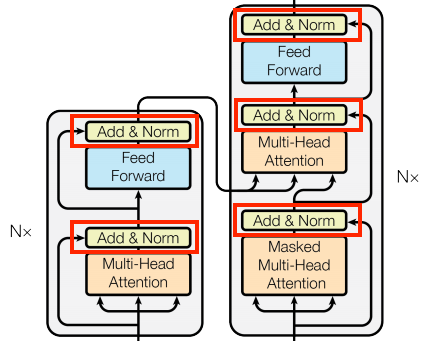

The Transformer model utilizes "Add & Norm" blocks to facilitate efficient training. These blocks incorporate two essential components: a residual connection and a LayerNormalization layer.

The residual connection establishes a direct path for the gradient, ensuring that vectors are updated rather than entirely replaced by the attention layers. This helps with gradient flow during training. On the other hand, the LayerNormalization layer maintains a reasonable scale for the outputs, enhancing the stability and performance of the model.

#### **BaseAttention layer:**
The attention mechanism is the core component of the Transformer model. It enables the model to focus on the relevant parts of the input sequence when processing each token. This is achieved by calculating the attention weights between each token's query and key vectors in the sequence. The attention weights are then multiplied by the value vectors to obtain the context vector, which is the output of the attention layer.

In [17]:
class BaseAttention(tf.keras.layers.Layer):
    """
    Base class for all attention layers. It contains the common functionality of all attention layers.
    This layer contains a MultiHeadAttention layer, a LayerNormalization layer and an Add layer.
    It is used as a base class for the GlobalSelfAttention, CausalSelfAttention and CrossAttention layers.
    And it is not intended to be used directly.

    Methods:
        call: Performs the forward pass of the layer.

    Attributes:
        mha (tf.keras.layers.MultiHeadAttention): The MultiHeadAttention layer.
        layernorm (tf.keras.layers.LayerNormalization): The LayerNormalization layer.
        add (tf.keras.layers.Add): The Add layer.
    """
    def __init__(self, **kwargs: dict):
        """ Constructor of the BaseAttention layer.
        
        Args:
            **kwargs: Additional keyword arguments that are passed to the MultiHeadAttention layer, e. g. 
                        num_heads (number of heads), key_dim (dimensionality of the key space), etc.
        """
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()

Within the class, there are three essential layers: **tf.keras.layers.MultiHeadAttention**, **tf.keras.layers.LayerNormalization**, and **tf.keras.layers.Add**:

1. The **MultiHeadAttention** layer computes the attention weights, which determine the relevance or importance of different parts of the input and output sequences;

2. The **LayerNormalization** layer normalizes the layer's activations, ensuring they have a consistent scale across batch and feature dimensions;

3. The **Add** layer incorporates a residual connection. It adds the output of the MultiHeadAttention layer to the original input sequence, allowing the model to retain information from the initial input while incorporating the attention-based updates.

An attention layer has two main inputs: the **query** and **context** sequences. The query sequence represents the sequence we focus on, while the context sequence is the one we seek information from. The output of the attention layer has the same shape as the query sequence.

The operation of an attention layer can be likened to a dictionary lookup but with some distinct characteristics. Like a regular dictionary, a query is used to search for relevant information represented by keys and values. In a standard dictionary, an exact match between the query and a key is necessary to retrieve the corresponding value. However, in an attention layer, the match does not need to be exact; it can be fuzzy or approximate.

For example, if we searched for the key "species" in the dictionary ***{'color': 'blue', 'age': 22, 'type': 'pickup'}***, the best match might be the value "pickup" even though the query and key don't match perfectly.

So now, let's use this class to create other attention layers. We will create:

1. The cross-attention layer: Decoder-encoder attention;
2. The global self-attention layer: Encoder self-attention;
3. The causal self-attention layer: Decoder self-attention.

### **CrossAttention layer**

The cross-attention layer is used to calculate the attention weights between the encoder and decoder sequences: 

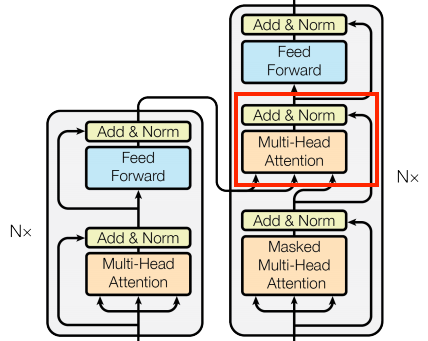

The **query** vectors are taken from the **decoder**, while the **key** and **value** vectors are taken from the encoder. Using this method, the decoder can concentrate on the essential sections of the input sequence while producing a token for each position.

When implementing this layer, we pass the target (expected Transformer results) sequence x as the query and the context (inputs to the Encoder layer) sequence as the value and key:

In [18]:
class CrossAttention(BaseAttention):
    """
    A class that implements the cross-attention layer by inheriting from the BaseAttention class.
    This layer is used to process two different sequences and attends to the context sequence while processing the query sequence.

    Methods:
        call: Performs the forward pass of the layer.    

    Attributes:
        mha (tf.keras.layers.MultiHeadAttention): The MultiHeadAttention layer.
        layernorm (tf.keras.layers.LayerNormalization): The LayerNormalization layer.
        add (tf.keras.layers.Add): The Add layer.
    """
    def call(self, x: tf.Tensor, context: tf.Tensor) -> tf.Tensor:
        """
        The call function that performs the cross-attention operation.

        Args:
            x (tf.Tensor): The query (expected Transformer results) sequence of shape (batch_size, seq_length, d_model).
            context (tf.Tensor): The context (inputs to the Encoder layer) sequence of shape (batch_size, seq_length, d_model).

        Returns:
            tf.Tensor: The output sequence of shape (batch_size, seq_length, d_model).
        """
        attn_output, attn_scores = self.mha(query=x, key=context, value=context, return_attention_scores=True)

        # Cache the attention scores for plotting later.
        self.last_attn_scores = attn_scores

        x = self.add([x, attn_output])
        x = self.layernorm(x)

        return x

You can see that the output shape from the CrossAttention layer is the same as the decoder embedding shape. This is because the output of the cross-attention layer is the same as the query sequence, which is the target sequence in this case. The simplified diagram below illustrates the information flow in the cross-attention layer:

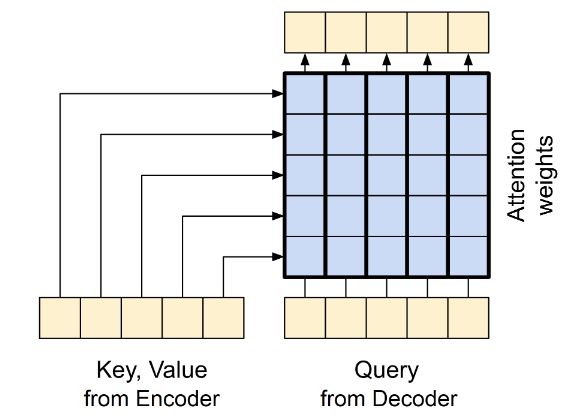

### GlobalSelfAttention layer

The GlobalSelfAttention layer is responsible for processing the context (encoder input) sequence and propagating information along its length:

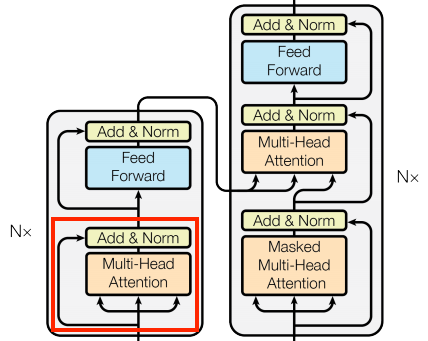


The **GlobalSelfAttention** layer allows each element in a sequence to easily access all other elements with minimal effort, and all results can be calculated simultaneously.

To implement this layer, it is crucial to supply the target sequence, x, as the query and value arguments to the mha layer.

In [19]:
class GlobalSelfAttention(BaseAttention):
    """
    A class that implements the global self-attention layer by inheriting from the BaseAttention class.
    This layer is used to process a single sequence and attends to all the tokens in the sequence.

    Methods:
        call: Performs the forward pass of the layer.

    Attributes:
        mha (tf.keras.layers.MultiHeadAttention): The MultiHeadAttention layer.
        layernorm (tf.keras.layers.LayerNormalization): The LayerNormalization layer.
        add (tf.keras.layers.Add): The Add layer.
    """
    def call(self, x: tf.Tensor) -> tf.Tensor:
        """
        The call function that performs the global self-attention operation.

        Args:
            x (tf.Tensor): The input sequence of shape (batch_size, seq_length, d_model).

        Returns:
            tf.Tensor: The output sequence of shape (batch_size, seq_length, d_model).
        """
        attn_output = self.mha(query=x, value=x, key=x)
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

The Multi-Head Attention (MHA) mechanism calculates a weighted average of values based on the similarity between queries and keys. The attention scores assigned to each value determine its importance.

In simpler terms, the MHA learns to focus on different parts of the input sequence, allowing the model to extract relevant information for a specific task. In the case of GlobalSelfAttention, where the input sequence serves as both the query and key, it captures the relationships between each position and all other positions in the sequence. We can visualize this process as follows:


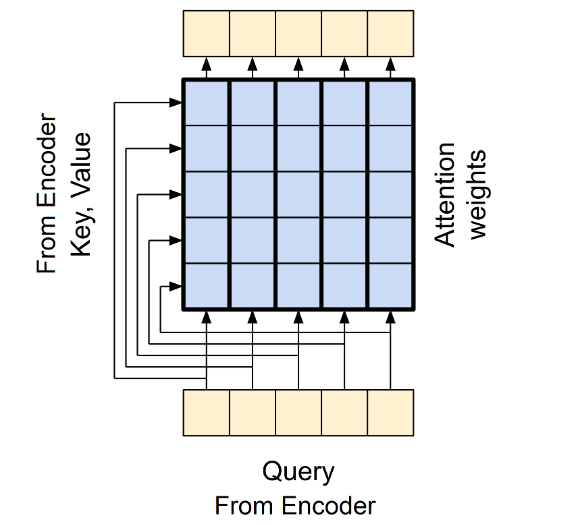

### **CausalSelfAttention layer**

The **CausalSelfAttention** layer is responsible for processing the target (decoder input) sequence and propagating information along its length:

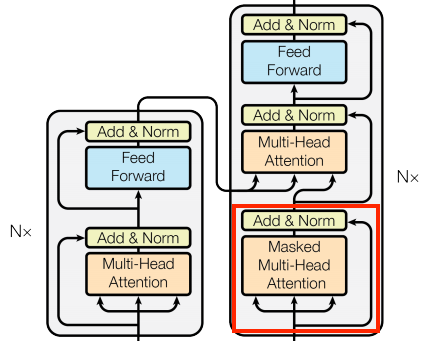

But the **CausalSelfAttention** layer differs from **GlobalSelfAttention** because it prevents leftward information flow in the decoder. Masking is crucial in this process, as it prevents the model from attending to future tokens during training. This masking process is illustrated in the diagram below

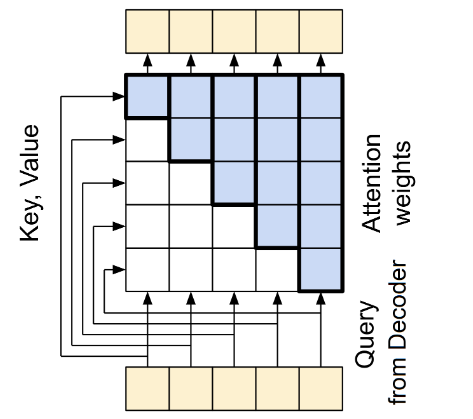

In [20]:
class CausalSelfAttention(BaseAttention):
    """
    Call self attention on the input sequence, ensuring that each position in the 
    output depends only on previous positions (i.e. a causal model).

    Methods:
        call: Performs the forward pass of the layer.

    Attributes:
        mha (tf.keras.layers.MultiHeadAttention): The MultiHeadAttention layer.
        layernorm (tf.keras.layers.LayerNormalization): The LayerNormalization layer.
        add (tf.keras.layers.Add): The Add layer.
    """
    def call(self, x: tf.Tensor) -> tf.Tensor:
        """
        The call function that performs the causal self-attention operation.
        
        Args:
            x (tf.Tensor): The input sequence of shape (batch_size, seq_length, d_model).

        Returns:
            tf.Tensor: The output sequence of shape (batch_size, seq_length, d_model).
        """
        attn_output = self.mha(query=x, value=x, key=x, use_causal_mask = True)
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

### FeedForward layer

Looking closer at the encoder and decoder layers, we can see that there is a FeedForward layer after each attention layer:

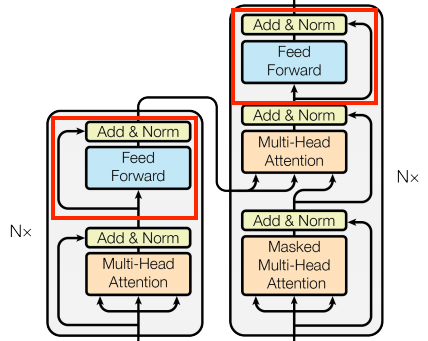


The **FeedForward** layer comprises two dense layers that are individually and uniformly applied to every position. The FeedForward layer is primarily used to transform the representation of the input sequence into a more suitable form for the task at hand. This is achieved by applying a linear transformation followed by a non-linear activation function. The output of the FeedForward layer has the same shape as the input, which is then added to the original input.

Let's implement this layer:


In [21]:
class FeedForward(tf.keras.layers.Layer):
    """
    A class that implements the feed-forward layer.

    Methods:
        call: Performs the forward pass of the layer.

    Attributes:
        seq (tf.keras.Sequential): The sequential layer that contains the feed-forward layers. It applies the two feed-forward layers and the dropout layer.
        add (tf.keras.layers.Add): The Add layer.
        layer_norm (tf.keras.layers.LayerNormalization): The LayerNormalization layer.
    """
    def __init__(self, d_model: int, dff: int, dropout_rate: float=0.1):
        """
        Constructor of the FeedForward layer.

        Args:
            d_model (int): The dimensionality of the model.
            dff (int): The dimensionality of the feed-forward layer.
            dropout_rate (float): The dropout rate.
        """
        super().__init__()
        self.seq = tf.keras.Sequential([
            tf.keras.layers.Dense(dff, activation='relu'),
            tf.keras.layers.Dense(d_model),
            tf.keras.layers.Dropout(dropout_rate)
        ])
        self.add = tf.keras.layers.Add()
        self.layer_norm = tf.keras.layers.LayerNormalization()

    def call(self, x: tf.Tensor) -> tf.Tensor:
        """
        The call function that performs the feed-forward operation. 

        Args:
            x (tf.Tensor): The input sequence of shape (batch_size, seq_length, d_model).

        Returns:
            tf.Tensor: The output sequence of shape (batch_size, seq_length, d_model).
        """
        x = self.add([x, self.seq(x)])
        x = self.layer_norm(x) 
        return x